# Introduction Bayesian Linear Regression Project
In this notebook, we will implement a complete machine learning project, focusing on bayesian inference method, in particular, Bayesian Linear Regression. We will go through the entire machine learning process, cleaning the data, exploring it to find trends, establishing a baseline model, evaluating several machine learning approaches for comparisons, implementing Bayesian Linear Regression, interpreting the results, and presenting the results. Let's get started.

## Dataset
We are using data on student grades collected from a Portugese secondary (high) school. This data is from the _[UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/student+performance)_, a great collection of datasets for model testing. The data includes academic and personal characteristics of the students as well as final grades. The objective is to predict the final grade form the student information which makes this a supervised, regression task. We have a set of training data with known labels, and we want the model to learn a mapping from the features (explanatory variables) to the target (the label) in this case the final grade. It is the regression task because the final grades is a continuous value.

# Exploratory Data Analysis

In [23]:
# Pandas and numpy for data manipulation
import pandas as pd
import numpy as np
np.random.seed(42)

 
# Matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
%matplotlib inline

import matplotlib
matplotlib.rcParams['font.size'] = 16
matplotlib.rcParams['figure.figsize'] = (9, 9)

import seaborn as sns

from IPython.core.pylabtools import figsize

# Scipy helper functions
from scipy.stats import percentileofscore
from scipy import stats

In [3]:
# Standard ML Models for comparisons
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR

# Splitting data into training and testing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, median_absolute_error

# Distributions
import scipy

In [4]:
# PyMC3 for Bayesian Inference
import pymc3 as pm

WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
C:\Users\Asus\Anaconda3\lib\site-packages\theano\configdefaults.py:560: UserWarning: DeprecationWarning: there is no c++ compiler.This is deprecated and with Theano 0.11 a c++ compiler will be mandatory
  warnings.warn("DeprecationWarning: there is no c++ compiler."
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


## Read in data and examine

In [5]:
# Read in class scores
df = pd.read_csv('data/student.csv')

# Filter out grades that were 0
df = df[~df['G3'].isin([0,1])]
df = df.rename(columns = {'G3': 'Grade'})

df.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,Grade
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,4,0,11,11
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,2,9,11,11
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,6,12,13,12
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,0,14,14,14
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,0,11,13,13


In [6]:
df.shape

(633, 33)

## Describe the numerical columns

In [7]:
df.describe()

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,Grade
count,633.000000,633.000000,633.000000,633.000000,633.000000,633.000000,633.000000,633.000000,633.000000,633.000000,633.000000,633.000000,633.000000,633.000000,633.000000,633.000000
mean,16.720379,2.519747,2.320695,1.563981,1.941548,0.206951,3.932070,3.169036,3.184834,1.489731,2.268562,3.527646,3.751975,11.503949,11.756714,12.205371
std,1.214044,1.133497,1.102284,0.750167,0.833284,0.579023,0.946411,1.047082,1.162014,0.912452,1.281776,1.448355,4.662003,2.682645,2.629715,2.656882
min,15.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,5.000000,5.000000
25%,16.000000,2.000000,1.000000,1.000000,1.000000,0.000000,4.000000,3.000000,2.000000,1.000000,1.000000,2.000000,0.000000,10.000000,10.000000,10.000000
50%,17.000000,2.000000,2.000000,1.000000,2.000000,0.000000,4.000000,3.000000,3.000000,1.000000,2.000000,4.000000,2.000000,11.000000,12.000000,12.000000
75%,18.000000,4.000000,3.000000,2.000000,2.000000,0.000000,5.000000,4.000000,4.000000,2.000000,3.000000,5.000000,6.000000,13.000000,13.000000,14.000000
max,22.000000,4.000000,4.000000,4.000000,4.000000,3.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,32.000000,19.000000,19.000000,19.000000


## Value counts for Categorical columns

In [8]:
# Print the value counts for categorical columns
for col in df.columns:
    if df[col].dtype == 'object':
        print('\nColumn Name: ', col,)
        print(df[col].value_counts())


Column Name:  school
GP    421
MS    212
Name: school, dtype: int64

Column Name:  sex
F    376
M    257
Name: sex, dtype: int64

Column Name:  address
U    446
R    187
Name: address, dtype: int64

Column Name:  famsize
GT3    443
LE3    190
Name: famsize, dtype: int64

Column Name:  Pstatus
T    555
A     78
Name: Pstatus, dtype: int64

Column Name:  Mjob
other       249
services    135
at_home     131
teacher      70
health       48
Name: Mjob, dtype: int64

Column Name:  Fjob
other       359
services    175
at_home      41
teacher      35
health       23
Name: Fjob, dtype: int64

Column Name:  reason
course        279
home          146
reputation    141
other          67
Name: reason, dtype: int64

Column Name:  guardian
mother    444
father    149
other      40
Name: guardian, dtype: int64

Column Name:  schoolsup
no     566
yes     67
Name: schoolsup, dtype: int64

Column Name:  famsup
yes    393
no     240
Name: famsup, dtype: int64

Column Name:  paid
no     595
yes     38
Nam

### Distribution of Grades

In [9]:
df['Grade'].describe()

count    633.000000
mean      12.205371
std        2.656882
min        5.000000
25%       10.000000
50%       12.000000
75%       14.000000
max       19.000000
Name: Grade, dtype: float64

In [11]:
df['Grade'].value_counts()

11    104
10     97
13     82
12     72
14     63
15     49
16     36
9      35
8      35
17     29
18     15
7      10
6       3
19      2
5       1
Name: Grade, dtype: int64

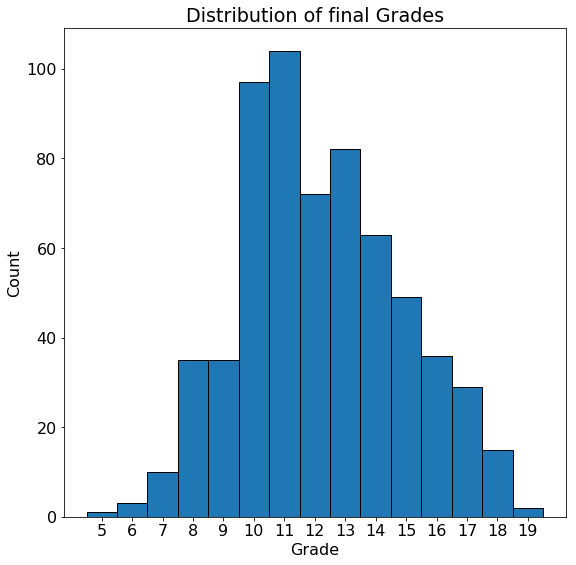

In [24]:
# Bar plot of Grades
plt.bar(df['Grade'].value_counts().index,
       df['Grade'].value_counts().values,
       fill = 'navy', edgecolor = 'k', width = 1)
plt.xlabel('Grade'); plt.ylabel('Count'); plt.title('Distribution of final Grades');
plt.xticks(list(range(5, 20)));

The Grade are close to normally distributed with a mode at 11 and mean at 12.20 (the grading in this school goes from 0-20). While the overall grades do not have a noticeable skew, it's possible that students from certain categories will have skewed grades. To look at the effect of categorical variables on the grade we can make density plots of the grade distribution colored by te value of the categorical variable. For this we use the seaborn library and the kdeplot function.

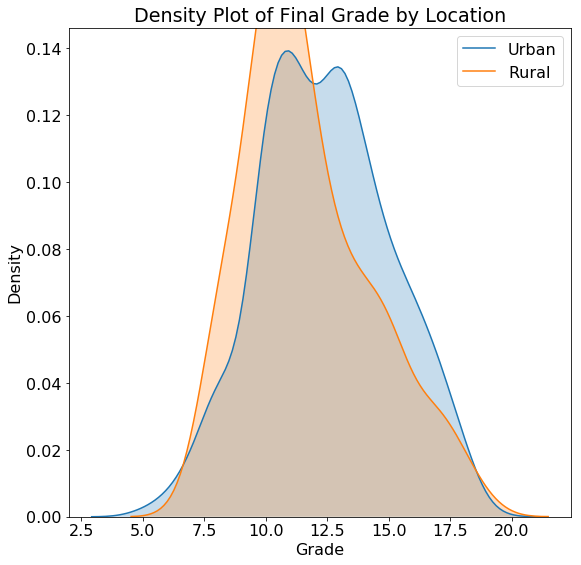

In [25]:
# Grade distibution by address
sns.kdeplot(df.loc[df['address'] == 'U', 'Grade'], label = 'Urban', shade = True)
sns.kdeplot(df.loc[df['address'] == 'R', 'Grade'], label = 'Rural', shade = True)
plt.xlabel('Grade'); plt.ylabel('Density'); plt.title('Density Plot of Final Grade by Location');

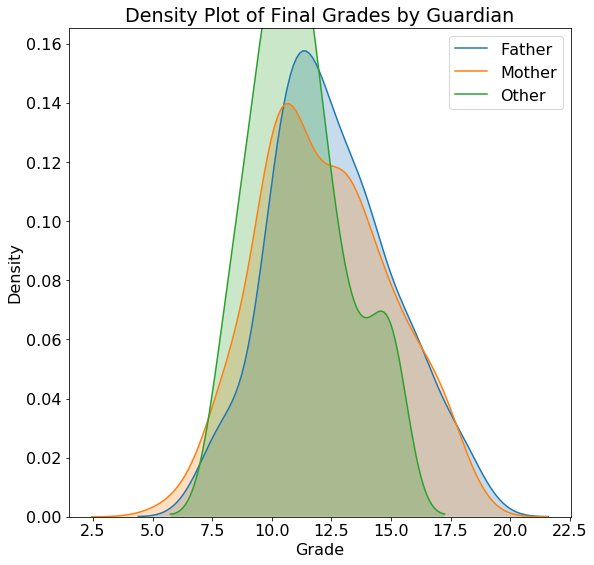

In [32]:
# Grade distribution by Guardian
sns.kdeplot(df.loc[df['guardian'] == 'father', 'Grade'], label = 'Father', shade = True)
sns.kdeplot(df.loc[df['guardian'] == 'mother', 'Grade'], label = 'Mother', shade = True)
sns.kdeplot(df.loc[df['guardian'] == 'other', 'Grade'], label = 'Other', shade = True)
plt.xlabel('Grade'); plt.ylabel('Density'); plt.title('Density Plot of Final Grades by Guardian');